TODO:

- Write up the Integration section
- Write up the Ratio Method section
- Write up the Mainsail section
- Compare them
    - Show quantitatively where the differences come from

# Analysis of Dwell Time Aggregations

A brief discourse on how dwell time can be aggregated accurately and comparison to Mainsail's method of aggregating dwell time.

## Summary

The average dwell time is
\begin{equation*}
\left<d\right>_C=\frac{\sum_C d_c}{\left|C\right|} \tag{1}
\end{equation*}
where $\left<\ldots\right>$ signifies an average; the subscript $C$ on $\left<\ldots\right>_C$ means the average is taken of the set of containers $C$; $d_c$ is the dwell time of container $c$ which is in the set of container $C$; the set of containers $C$ is the set of containers on the terminal at the time that the average dwell time is measured; and the count of containers in $C$ is $\left|C\right|$. In short, it's the average amount of time that the containers have been on the terminal at a specific moment in time.

The dwell time $d_c$ and the container count $\left|C\right|$ are both functions of time $t$. This means that the average dwell time $\left<d\right>_C$ is a function of time too.
\begin{equation*}
\left<d\right>_C(t)=\frac{\sum_C d_c(t)}{\left|C(t)\right|}
\end{equation*}
The usual way to aggregate a metric that changes over time like the average dwell time $\left<d\right>_C(t)$ is to average it. This mean that in this case the dwell time must be averaged over the set of containers $C$ and over a period $T$ to get the aggregated average dwell time $\left<d\right>_{C,T}$ where the two subscripts $C$ and $T$ of $\left<\ldots\right>_{C,T}$ mean that the dwell time has been averaged over two dimensions: the set of containers $C$ and the period $T$.

The word 'aggregate' will be used instead of 'average' when working with time to avoid confusion. Four methods for aggregating the average dwell time over a period are examined:

- Sampling
- Integration
- The ratio of averages
- The Mainsail metric

### Notation

Mathematical notation is kept to a minimum. The notationss are listed here for easy reference.

- $d$: the dwell time
- $d_c$: the dwell time for a single container $c$ in the set of containers $C$
- $d_c(t)$: the dwell time for a single container $c$ at a moment in time $t$
- $C$: the set of containers on the terminal
- $C(t)$: the set of container on the terminal at time $t$
- $\left<d\right>$: the average dwell time
- $\left<d\right>_C$: the average dwell time over the set of containers $C$
- $\left<d\right>_C(t)$: the average dwell time over the set of containers $C$ at time $t$
- $\left<d\right>_{C,T}$: the average dwell time over the set of containers $C$ and over the period $T$
- $\sum_Cd_c$: the sum of the dwell times of every container in the set of containers $C$, that is, the total dwell time
- $\left<\sum_Cd_c\right>_T$: the average of the total dwell time over the period $T$
- $\left<C\right>_T$: the average count of containers in the set $C$ over the period $T$
- $N$: the number of samples taken when using the sampling method
- $\int_0^T\left<d\right>_C$: the area under the plot of $\left<d\right>_C$
- $\left<d\right>_D$: the average dwell time for the containers that arrived and departed during the period
- $\left|D\right|$: the count of containers that arrive and depart during the period

## Average Dwell Time Aggregations

The methods for aggregating the average dwell time $\left<d\right>_C$ over a period $T$ considered are:

- Sampling
- Integration
- The ratio of the averages
- The Mainsail metric

The preferred aggregation of the Crow's Nest time is the ratio of the averages. It permits the end user to filter the container set at runtime and is an excellent approximation to the exact value of the aggregated average dwell time $\left<d\right>_{C,T}$.

Sampling is examined because it is easy to understand and because it is also an excellent approximation to the exact value of $\left<d\right>_{C,T}$. 

Integration is examined because it computes an exact value for $\left<d\right>_{C,T}$. It is diffcult to understand, complex to implement, and does not permit the end user to filter the container set at runtime. However, for this document it provides significant value by providing the correct answer.

The Mainsail metric is examined to understand the differences between it and value produced by the previous three aggregations.

## Methods

All aggregations have been written in Python as part of this notebook. All cells may be executed. Executing the entire notebook takes approximately three hours.

The following cell imports some libraries that are used.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import datetime

The next cell defines the function that is used to perform the aggregations.

In [2]:
def dwell_times(container_times, sampling_interval, first_day, last_day, print_setting, debug_setting, overlay_setting):

    def plot_segments(segments, x1, x2, y1, y2, xTitle, yTitle, plotTitle, color, show, time_start, time_end):
        # Create the plot object
        for i in range(len(segments)):
            plt.plot([segments.loc[i, x1], segments.loc[i, x2]]
                      , [segments.loc[i, y1], segments.loc[i, y2]]
                     , color=color)
        
        # Display the plot
        plt.xticks(rotation=90)
        plt.xlim(time_start, time_end)
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.title(plotTitle)
        if show:
            plt.show()
        return plt

    def return_zero_for_div_by_zero(numerators, divisors):
        return [num / div if div != 0 else 0 for num, div in zip(numerators, divisors)]

    def initial_dwell(box_schedule_df_row, start_time):
        if start_time >= box_schedule_df_row['departure']:
            return(0)
        elif start_time <= box_schedule_df_row['arrival']:
            return(0)
        else:
            return (start_time - box_schedule_df_row['arrival']).total_seconds()

    # The users can input a time table of arrivals and departures for containers. The users can also
    # select dates that they are interested in. This is so that we can eventually supply a list of
    # all the containers that were on the terminal for those dates and report metrics only for those
    # dates instead of from the earliest event to the latest.

    # I had to remove Timedelta objects from some uses as they have a maximum value of around 100K
    # days which is too small for all purposes. I use seconds as the unit for all time intervals
    # and convert where necessary to days.

    # The integration method needs a dataframe with a grain of one row per interval between inventory
    # change events per day. If an interval stretches over two or more days, then it needs to be split.

    # The sampling method needs a dataframe with a grain of one row per sample.

    # The ratio method needs a dataframe with a grain of one row per container per day.

    # The mainsail method needs a dataframe with a grain of one row per container. Selection of rows will
    # be used to get individual days.

    # Let's setup the user-input data.

    container_times_df = pd.DataFrame(container_times)
    if debug_setting:
        print(container_times_df)
    container_times_df['arrival'] = container_times_df['arrival'].apply(lambda x: pd.to_datetime(x))
    container_times_df['departure'] = container_times_df['departure'].apply(lambda x: pd.to_datetime(x))
    container_times_df['dwell'] = (container_times_df['departure'] - container_times_df['arrival']).apply(lambda x: x.total_seconds())

    # And the rest of the user input
    sampling_timedelta = pd.Timedelta(hours=sampling_interval)
    start_time = pd.to_datetime(first_day)
    end_time = pd.to_datetime(last_day) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    if debug_setting:
        print('start_time: ', start_time)
        print('end_time: ', end_time)
    first_day = start_time.date()
    last_day = end_time.date()
    date_df = pd.DataFrame(pd.date_range(start=first_day, end=last_day), columns=['day_actual'])
    date_df['day_actual'] = date_df['day_actual'].apply(lambda x: x.date())
    period = (end_time - start_time).total_seconds()

    # To create the integration dataframe with a grain of one row per interval between inventory change
    # events per day, I need to create an event list and then join it to itself, shifting by one row,
    # to get intervals.

    # Building the integration dataframe first is a good choice. We'll use it to produce the plots too.
    
    # Let's unpivot the input time table to get arrival and departure events.
    integration_df = pd.melt(
        pd.DataFrame(container_times_df)
        , id_vars=['container']
        , value_vars=['arrival', 'departure']
        , var_name='event_type'
        , value_name='event_time'
    )
    integration_df = integration_df.sort_values(by='event_time', ascending=True)
    integration_df['box_count_incr'] = (
        integration_df['event_type'].apply(lambda x: 1 if x == 'arrival' else -1)
    )
    integration_df['box_count'] = integration_df['box_count_incr'].cumsum()
    integration_df['event_start_day'] = pd.to_datetime(integration_df['event_time']).apply(lambda x: x.date())
    integration_df['next_container'] = integration_df['container'].shift(-1)
    integration_df['next_event_type'] = integration_df['event_type'].shift(-1)
    integration_df['next_event_time'] = integration_df['event_time'].shift(-1)
    integration_df['event_end_day'] = pd.to_datetime(integration_df['next_event_time'].apply(lambda x: x.date()))
    # At this point, let's split the intervals by day.
    
    conn = sqlite3.connect(':memory:')
    
    integration_df.to_sql('integration_df', conn, index=False)
    date_df.to_sql('date_df', conn, index=False)
    query = '''
        select *
        from integration_df
        inner join date_df on
            date_df.day_actual between integration_df.event_start_day and integration_df.event_end_day
    '''
    integration_df = pd.read_sql_query(query, conn)
    integration_df['event_time'] = integration_df['event_time'].apply(lambda x: pd.to_datetime(x))
    integration_df['event_start_day'] = integration_df['event_start_day'].apply(lambda x: pd.to_datetime(x))
    integration_df['next_event_time'] = integration_df['next_event_time'].apply(lambda x: pd.to_datetime(x))
    integration_df['event_end_day'] = integration_df['event_end_day'].apply(lambda x: pd.to_datetime(x))
    integration_df['day_actual'] = integration_df['day_actual'].apply(lambda x: pd.to_datetime(x))
    integration_df['interval_start_time'] = np.maximum(integration_df['event_time'], integration_df['day_actual'])
    integration_df['interval_end_time'] = np.minimum(integration_df['next_event_time'], integration_df['day_actual'] + pd.Timedelta(days=1))
    integration_df['duration'] = (integration_df['interval_end_time'] - integration_df['interval_start_time']).apply(lambda x: x.total_seconds())
    # The dwell_rise is the amount of dwell time gained during the intervals. It's the product of the box count and the duration.
    integration_df['dwell_rise'] = integration_df['duration'] * integration_df['box_count']
    # Here I need to merge the container_times_df so that I can get the dwell for each container for the entire visit.
    # I need the dwell for each container for the entire visit so that I can subtract the dwell time out of the cumulative sum
    # when the container departs.
    integration_df = pd.merge(integration_df, container_times_df, on='container', how='inner')
    integration_df['dwell_loss'] = (
        integration_df.apply(
            lambda row: -1 * row['dwell']
                if (row['event_type'] == 'departure') & (row['event_start_day'] == row['day_actual'])
                else 0
            , axis=1
        )
    )
    # The dwell time increment for the interval is the sum of the dwell_rise and the dwell_loss.
    integration_df['dwell_incr'] = integration_df['dwell_rise'] + integration_df['dwell_loss']
    # The cumulative sum is a handy way to get the total dwell at the end of the interval.
    # Since we don't start with an empty yard, we need to add the initial total dwell.
    container_times_df['initial_dwell'] = container_times_df.apply(lambda row: initial_dwell(row, start_time), axis=1)
    initial_total_dwell = container_times_df['initial_dwell'].sum()
    if debug_setting:
        print('integration_df:\n', integration_df, '\n')
        print('initial_total_dwell:\n', initial_total_dwell, '\n')
    integration_df['ending_dwell'] = integration_df['dwell_incr'].cumsum() + initial_total_dwell
    # And the starting dwell can be obtained easily enough be subtracting the dwell_rise.
    integration_df['starting_dwell'] = (integration_df['ending_dwell'] - integration_df['dwell_rise'])
    # The average dwell at the end points of the interval can be computed from the total dwell 
    # by dividing by the box count.
    integration_df['starting_avg_dwell'] = integration_df['starting_dwell'] / integration_df['box_count']
    integration_df['ending_avg_dwell'] = integration_df['ending_dwell'] / integration_df['box_count']
    integration_df['avg_dwell_rise'] = integration_df['ending_avg_dwell'] - integration_df['starting_avg_dwell']

    # Let's produce the plots now.
    segments = integration_df.copy()
    segments = segments.drop(columns=[
                        'container','event_type','box_count_incr'
                        ,'next_container','next_event_type','duration','dwell_rise'
                        ,'arrival','departure','dwell','dwell_loss'
                        ,'dwell_incr','day_actual'
                        ,'event_time','event_start_day','next_event_time','event_end_day'])

    # Convert to days
    segments['starting_dwell_days'] = segments['starting_dwell']/86400
    segments['ending_dwell_days'] = segments['ending_dwell']/86400

    
    if print_setting:
        # Total dwell time plot
        plot_segments(segments, 'interval_start_time', 'interval_end_time', 'starting_dwell_days', 'ending_dwell_days',
                      'Time', 'Total Dwell (days)', 'Total Dwell Time Over Time', '#36454F', True, start_time, end_time)
    
        # Box count plot
        plot_segments(segments, 'interval_start_time', 'interval_end_time', 'box_count', 'box_count',
                      'Time', 'Container Count', 'Container Count Over Time', '#36454F', True, start_time, end_time)
        #print('avg box count:\n', segments['box_count'].mean())
    
    # Let's produce the sampling times and sampled avg dwells for overlay on the avg dwell plot next.
    # The sample_offset let's us sample in the middle of the interval instead of at the beginning.
    sample_offset = sampling_timedelta / 2
    sampling_times = pd.date_range(start=(start_time + sample_offset), end=end_time, freq=sampling_timedelta)
    sampling_df = pd.DataFrame(sampling_times, columns=['sampling_time'])
    # Joining the samples to the segments
    sampling_df.to_sql('sampling_df', conn, index=False)
    if debug_setting:
        print('segments:\n', segments, '\n')
    segments.to_sql('segments', conn, index=False)
    query = '''
        select *
        from sampling_df
        left join segments on
            sampling_df.sampling_time between segments.interval_start_time and segments.interval_end_time
    '''
    sampling_df = pd.read_sql_query(query, conn)
    # Use linear interpolation to obtain the sampled avg dwell time
    sampling_df['sample_dwell'] = (
        sampling_df['starting_avg_dwell'] +
        (sampling_df['sampling_time'].apply(pd.to_datetime) -
         sampling_df['interval_start_time'].apply(pd.to_datetime)).apply(lambda x: x.total_seconds())
    )
    sampling_df['sampling_time'] = pd.to_datetime(sampling_df['sampling_time'])
    # If there's no data, let the sample be 0.
    sampling_df['sample_dwell'] = sampling_df['sample_dwell'].fillna(0)
    
    # Avg dwell time plot
    if print_setting:
        segments['starting_avg_dwell_days'] = segments['starting_avg_dwell']/86400
        segments['ending_avg_dwell_days'] = segments['ending_avg_dwell']/86400
        avg_dwell_plot = plot_segments(segments, 'interval_start_time', 'interval_end_time', 'starting_avg_dwell_days', 'ending_avg_dwell_days',
                      'Time', 'Avg Dwell (days)', 'Avg Dwell Time Over Time', '#36454F', False, start_time, end_time)

        sampling_df['sample_dwell_days'] = sampling_df['sample_dwell']/86400
        if overlay_setting:
            avg_dwell_plot.scatter(sampling_df['sampling_time'], sampling_df['sample_dwell_days'], color='#36454F', label='Sampling Points')
        else:
            avg_dwell_plot.show()

    ## Now time to compute results
    # results_df = pd.DataFrame(columns=['Method', 'Timeframe', 'Value'])
    
    # Integration results
    integration_df['area'] = (
        integration_df['starting_avg_dwell'] * integration_df['duration']
            + 0.5 * integration_df['duration'] * integration_df['avg_dwell_rise']
        # Need avg_dwell_rise here because if there are not boxes, it's zero.
    )
    if debug_setting:
        with pd.option_context('display.max_columns', None):
            print('integration_df:\n')
            print(integration_df)
    integration_result_all = integration_df['area'].sum() / (end_time - start_time).total_seconds()
    
    daily_integration_results = integration_df.groupby('day_actual')['area'].sum().reset_index()
    daily_integration_results['avg_dwell'] = daily_integration_results['area']/86400
    daily_integration_results['Method'] = 'Integration'
    daily_integration_results['Timeframe'] = daily_integration_results['day_actual'].apply(lambda x: x.date())
    daily_integration_results['Avg Dwell'] = daily_integration_results['avg_dwell']
    daily_integration_results = daily_integration_results.drop(columns=['day_actual', 'avg_dwell', 'area'])
    
    integration_result_avg = daily_integration_results['Avg Dwell'].mean()
    
    results_df = pd.DataFrame([{'Method': 'Integration', 'Timeframe': 'Entire Period', 'Avg Dwell': integration_result_all}])
    results_df = pd.concat([results_df, daily_integration_results], ignore_index = True)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Integration'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': integration_result_avg
         }])]
        , ignore_index = True
    )
      
    # Sampling results
    sampling_result = sampling_df['sample_dwell'].mean()
    
    sampling_df['day_actual'] = sampling_df['sampling_time'].apply(lambda x: x.date())
    daily_sampling_results = sampling_df.groupby('day_actual')['sample_dwell'].mean().reset_index()
    daily_sampling_results = daily_sampling_results.rename(columns={'day_actual': 'Timeframe', 'sample_dwell': 'Avg Dwell'})
    daily_sampling_results['Avg Dwell'] = daily_sampling_results['Avg Dwell']
    daily_sampling_results['Method'] = 'Sampling'
    
    daily_sampling_avg = daily_sampling_results['Avg Dwell'].mean()
    if debug_setting:
        print('sampling_df:\n', sampling_df)

    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Sampling'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': sampling_result
         }])]
        , ignore_index = True
    )
    results_df = pd.concat([results_df, daily_sampling_results], ignore_index = True)
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Sampling'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_sampling_avg
         }])]
        , ignore_index = True
    )
    
    # Ratio results
    # The ratio method needs a dataframe with a grain of one row per container per day.
    ratio_df = container_times_df.copy()
    ratio_df['dwell'] = ratio_df['dwell']
    ratio_df['dwell_start_day'] = ratio_df['arrival'].apply(lambda x: x.date())
    ratio_df['dwell_end_day'] = ratio_df['departure'].apply(lambda x: x.date())
    if debug_setting:
        print('ratio_df:\n', ratio_df)
    ratio_df.to_sql('ratio_df', conn, index=False)
    query = '''
        select ratio_df.*, date(date_df.day_actual) as day_actual
        from ratio_df
        inner join date_df on date(date_df.day_actual) between ratio_df.dwell_start_day and ratio_df.dwell_end_day
    '''
    ratio_df = pd.read_sql_query(query, conn)
    ratio_df['arrival'] = ratio_df['arrival'].apply(lambda x: pd.to_datetime(x))
    ratio_df['departure'] = ratio_df['departure'].apply(lambda x: pd.to_datetime(x))
    ratio_df['dwell'] = ratio_df['dwell']
    ratio_df['dwell_start_day'] = ratio_df['dwell_start_day'].apply(lambda x: pd.to_datetime(x).date())
    ratio_df['dwell_end_day'] = ratio_df['dwell_end_day'].apply(lambda x: pd.to_datetime(x).date())
    ratio_df['day_actual'] = ratio_df['day_actual'].apply(lambda x: pd.to_datetime(x))
    ratio_df['end_of_day_actual'] = ratio_df['day_actual'] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    ratio_df['daily_duration_start'] = ratio_df[['arrival', 'day_actual']].max(axis=1)
    ratio_df['daily_duration_end'] = ratio_df[['departure', 'end_of_day_actual']].min(axis=1)
    ratio_df['daily_initial_dwell'] = (ratio_df['daily_duration_start'] - ratio_df['arrival']).apply(lambda x: x.total_seconds())
    ratio_df['daily_box_duration'] = (ratio_df['daily_duration_end'] - ratio_df['daily_duration_start']).apply(lambda x: x.total_seconds())
    # The avg dwell is the (initial dwell + the final dwell) / 2.
    # The final dwell is the (initial dwell + the daily box duration).
    # Substituting, the avg dwell is the initial dwell + the daily box duration / 2.
    ratio_df['daily_avg_dwell'] = ratio_df['daily_initial_dwell'] + ratio_df['daily_box_duration']/2
    ratio_df['daily_box_dwell_areas'] = ratio_df['daily_avg_dwell'] * ratio_df['daily_box_duration']
    if debug_setting:
        print('ratio_df:\n', ratio_df)

    ratio_result = ratio_df['daily_box_dwell_areas'].sum() / ratio_df['daily_box_duration'].sum()
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Ratio'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': ratio_result
         }])]
        , ignore_index = True
    )

    daily_ratio_results = ratio_df.groupby('day_actual').agg({'daily_box_dwell_areas': 'sum', 'daily_box_duration': 'sum'}).reset_index()  
    daily_ratio_results['Avg Dwell'] = daily_ratio_results['daily_box_dwell_areas'] / daily_ratio_results['daily_box_duration']
    daily_ratio_results = daily_ratio_results.drop(columns=['daily_box_dwell_areas', 'daily_box_duration'])
    daily_ratio_results = daily_ratio_results.rename(columns={'day_actual': 'Timeframe'})
    daily_ratio_results['Method'] = 'Ratio'
    daily_ratio_results['Timeframe'] = daily_ratio_results['Timeframe'].apply(lambda x: x.date())
    if debug_setting:
        print('daily_ratio_results:\n', daily_ratio_results)
    results_df = pd.concat([results_df, daily_ratio_results], ignore_index = True)
    
    daily_ratio_avg = daily_ratio_results['Avg Dwell'].mean()
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Ratio'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_ratio_avg
         }])]
        , ignore_index = True
    )

    # Mainsail metric computations
    mainsail_df = container_times_df.copy()
    # Mainsail truncates the arrivals and departures to compute the dwell
    mainsail_df['arrival'] = mainsail_df['arrival'].apply(lambda x: x.normalize())
    mainsail_df['departure'] = mainsail_df['departure'].apply(lambda x: x.normalize())
    mainsail_df['dwell'] = (mainsail_df['departure'] - mainsail_df['arrival']).apply(lambda x: x.total_seconds())
    if debug_setting:
        print('mainsail_df:\n', mainsail_df)
    mainsail_df = (
        mainsail_df[
            (mainsail_df['arrival'] >= start_time)
            & (mainsail_df['departure'] <= end_time)
        ]
    )
    if debug_setting:
        print('mainsail_df:\n', mainsail_df)
        print('mainsail total dwell = ', mainsail_df['dwell'].sum())
        print('mainsail box count = ', len(mainsail_df))
    mainsail_result = mainsail_df['dwell'].mean()
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Mainsail'
             , 'Timeframe': 'Entire Period'
             , 'Avg Dwell': mainsail_result
         }])]
        , ignore_index = True
    )

    mainsail_df = (
        mainsail_df[
            (mainsail_df['arrival'].apply(lambda x: x.date()) == mainsail_df['departure'].apply(lambda x: x.date()))
            & (mainsail_df['arrival'] >= start_time)
            & (mainsail_df['departure'] <= end_time)
        ]
    )
    mainsail_df['day_actual'] = mainsail_df['arrival'].apply(lambda x: x.date())
    mainsail_daily_results = mainsail_df.groupby('day_actual')['dwell'].mean().reset_index()
    # I want missed days to be zero.
    mainsail_daily_results = date_df.merge(mainsail_daily_results, on='day_actual', how='left')
    mainsail_daily_results['dwell'] = mainsail_daily_results['dwell'].fillna(0)
    mainsail_daily_results = mainsail_daily_results.rename(columns={'day_actual': 'Timeframe', 'dwell': 'Avg Dwell'})
    mainsail_daily_results['Method'] = 'Mainsail'
    mainsail_daily_results['Avg Dwell'] = mainsail_daily_results['Avg Dwell']
    results_df = pd.concat([results_df, mainsail_daily_results], ignore_index = True)
    if debug_setting:
        print('mainsail_daily_results:\n', mainsail_daily_results)
    daily_mainsail_avg = mainsail_daily_results['Avg Dwell'].mean()
    results_df = pd.concat(
        [results_df
         , pd.DataFrame([{
             'Method': 'Mainsail'
             , 'Timeframe': 'Avg Over Days'
             , 'Avg Dwell': daily_mainsail_avg
         }])]
        , ignore_index = True
    )

    results_df['Avg Dwell'] = results_df['Avg Dwell']/86400
    
    if debug_setting:
        print('mainsail_daily_results:\n', mainsail_daily_results)
    
    return(results_df)

To use the function a schedule of arrivals and departures for containers must be defined in `container_times`; a time interval between successive samples must be defined as `sampling_interval`; and the first and last day of the period of interest must be defined as `first_day` and `last_day`. 

The settings determine how verbose the output is.

- `print_setting` causes the charts to be output if set to `True`
- `debug_setting` prints out a large amount of internal variable data if set to `True`
- `overlay_setting` causes the sampling times and sampled average dwell times to be overlaid on the average dwell time chart if set to `True`

### Sampling

To demonstrate the sampling method, consider an empty yard that receives three containers that depart on the following schedule:

- Container A: Arrives at midnight on September 1; Departs at noon on September 2
- Container B: Arrives at noon on September 1; Departs at midnight on September 3
- Container C: Arrives at midnight on September 2; Departs the moment before midnight on September 3

Let the gap in time between successive samples be 12 hours and let's set the period of interest to be from September 1 through September 3.

In [3]:
box_schedules = {
    'container': ['A', 'B', 'C'],
    'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
    'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
}
sample_gap = 12
first_day = '2024-09-01'
last_day = '2024-09-03'

The previous cell codifies the example. The next cell runs it.

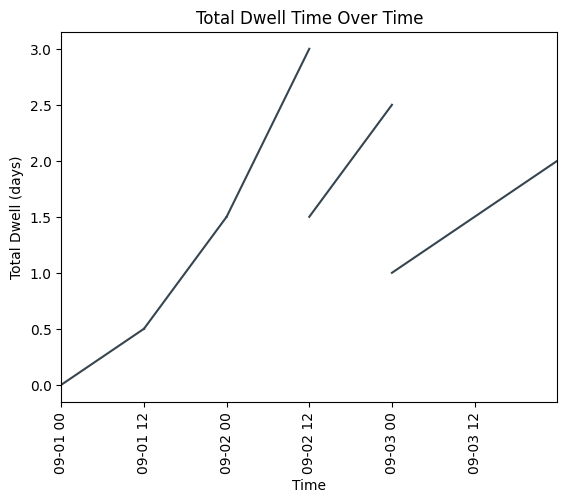

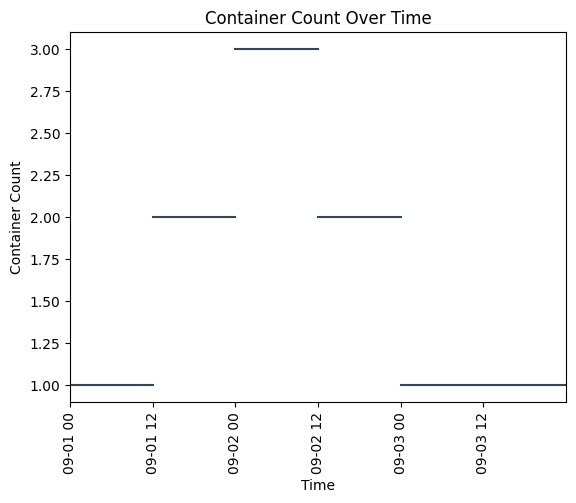

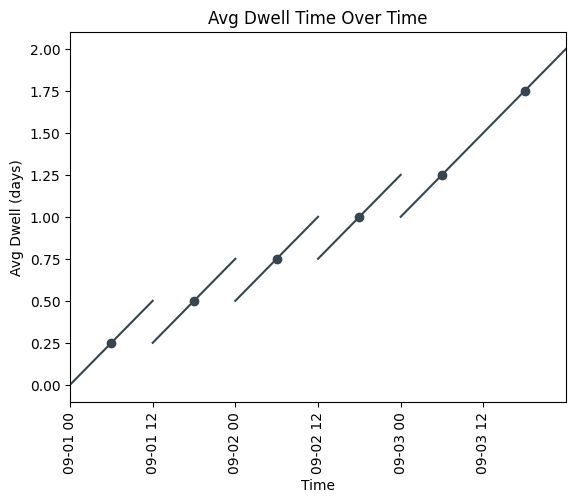

In [4]:
results = dwell_times(box_schedules, sample_gap, first_day, last_day, True, False, True)

#### Explicit Example
The next few paragraphs somewhat tediously work through the example explicitly so that the reader can verify the veracity of the charts and results. Skip to "How Sampling Works" to avois this tedium. Skip to "Integration" if you know how sampling works.

The first chart shows how the total dwell time changes over time. From midnight to noon on the 1st, Container A is the only box on the terminal. It arrived at midnight and so the total dwell time trends upward from 0 to 12 hours (0.5 days) from midnight to noon. Container B arrives at noon. From noon on the 1st to midnight on the 2nd, there are two containers on the terminal and 24 hours of dwell are added over those 12 hours of time. At the end of the 1st, the containers have a combined total dwell of 36 hours (1.5 days). At midnight on the second, Container C arrives and over the next 12 hours 36 additional hours of dwell accrues. The total dwell increases from 36 to 72 hours (3 days).

At noon on the 2nd, Container A leaves, removing 36 hours of dwell time from the total. It drops from 72 to 36 hours (1.5 days). Two containers remain and over the next 12 hours another 24 hours of dwell accrues so that at midnight on the 2nd the total dwell time is 60 hours (2.5 days). At that time, Container B departs, removing another 36 hours and dropping the total dwell from 60 to 24 hours (1 day). Container C is the only remaining container. It stays for 24 more hours (more or less) and so adds an additional 24 hours of dwell to make the final dwell time at the end of the 3rd 48 hours (2 days).

The second chart shows how the container count changes over time. From midnight to noon on the 1st, there's only 1 container, Container A. From noon to midnight on the 2nd there are 2; from midnight on the 2nd to noon there are 3; from noon to midnight on the 3rd, there are only 2 again; then there's only 1 container, Container C, on the terminal all day on the 3rd.

The third chart shows the average dwell time. The average dwell time is the first chart divided by the second chart. This means that for every point at time $t$ in the Total Dwell Time chart, it is divided by the point at the same time $t$ on the Container Count chart to get the point shown at time $t$ on the Average Dwell Time chart. For this example, the box count is either 1, 2, or 3, depending on the time. For the first half of the 1st and for all of the 3rd, the Total Dwell Time is divided by a container count of 1 to get the Average Dwell Time; that is, the Average Dwell Time equals the Total Dwell Time. For the second half of the 1st and the last half of the 2nd, the Total Dwell Time is divided by a container count of 2, and for the first half of the 2nd, the Total Dwell Time is divided by a container count of 3. This division results in the chart shown for the Average Dwell Time.

#### How Sampling Works

Sampling works by taking several measurements and then averaging the results of those measurement to obtain an average result for the period during which the samples were taken. If the samples are distributed regularly in time, then it is a good approximation to the exact average. The accuracy increases with greater numbers of samples, but so does the work involved in obtaining the result.

The sampling interval for the example is set to 12 hours. The function centers the sampling time in its interval so that the samples occur at 6 AM and 6 PM each day. The expectations for the results are shown in Table 1.

|Sample Time|Total Dwell (days)| Container Count| Sampled Average Dwell Time (days)|
|--|--|--|--|
|2024-09-01 0600| 0.25| 1| 0.25|
|2024-09-01 1800| 1.00| 2| 0.50|
|2024-09-02 0600| 2.25| 3| 0.75|
|2024-09-02 1800| 2.00| 2| 1.00|
|2024-09-03 0600| 1.25| 1| 1.25|
|2024-09-03 1800| 1.75| 1| 1.75|
_Table 1. Sample times and sampled total dwell, container count, and average dwell time values._

The sample times and sampled average dwell times have been marked with dots on the Average Dwell Time chart.

Here are the sampling results for the example:

In [5]:
results[results['Method']=='Sampling']

,Method,Timeframe,Avg Dwell
5,Sampling,Entire Period,0.916667
6,Sampling,2024-09-01,0.375000
7,Sampling,2024-09-02,0.875000
8,Sampling,2024-09-03,1.500000
9,Sampling,Avg Over Days,0.916667


The results present averages instead of results for individual samples. The rows with a date for the Timeframe are the average for that day. They agree with the average of the expected values for each day. The row with the Timeframe "Entire Period" averages all the samples together. The row with the Timeframe "Avg Over Days" averages the averages obtained from each day, 0.375, 0.875, and 1.5, in this case. 

The two rows "Entire Period" and "Avg Over Days" are presented separately because not every aggregation method is an exact average and the value obtained from averaging the entire period directly may not be identical to the average of the daily averages. This can be seen for the sampling method if some days have more samples than others.

In [6]:
box_schedules = {
    'container': ['A', 'B', 'C'],
    'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
    'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
}
sample_gap = 7
first_day = '2024-09-01'
last_day = '2024-09-03'

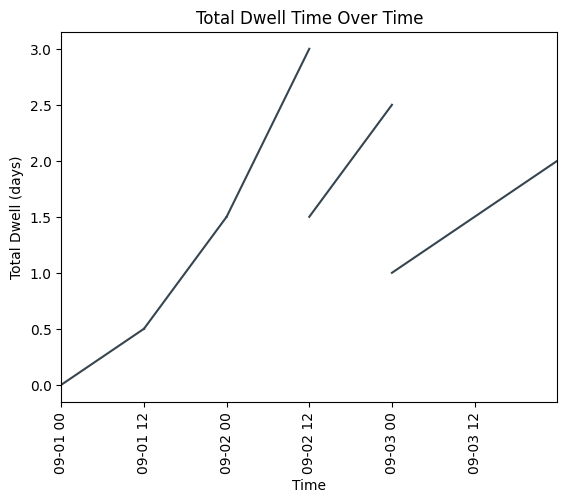

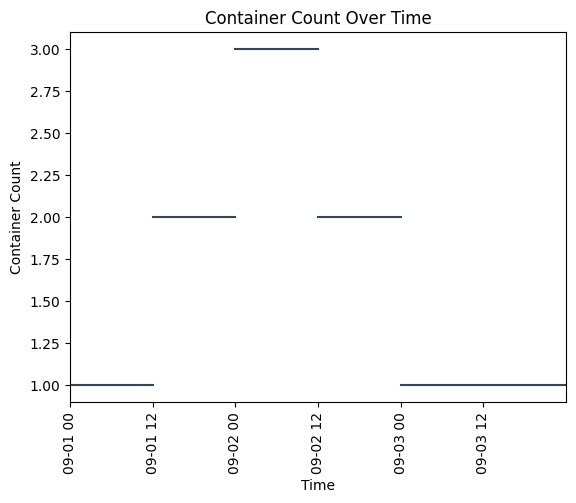

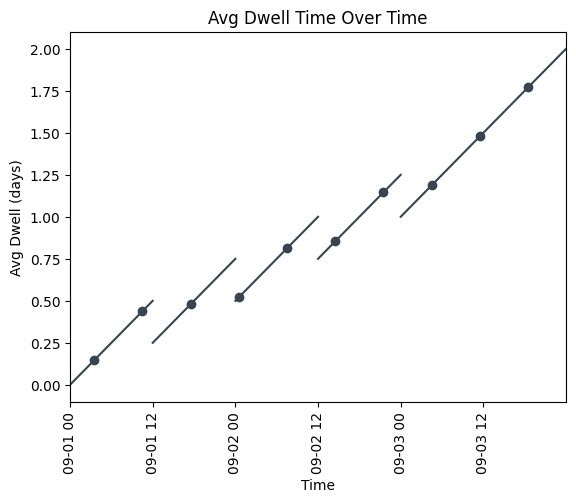

In [7]:
results = dwell_times(box_schedules, sample_gap, first_day, last_day, True, False, True)

In [8]:
results[results['Method']=='Sampling']

,Method,Timeframe,Avg Dwell
5,Sampling,Entire Period,0.883333
6,Sampling,2024-09-01,0.354167
7,Sampling,2024-09-02,0.833333
8,Sampling,2024-09-03,1.479167
9,Sampling,Avg Over Days,0.888889


### Integration

To obtain the average value for a continuous function like the average dwell time, the integral of the function is divided by the period. This means that the area under the curve of the average dwell time is computed and that area is divided by the duration of the period.

The area under the Average Dwell Time curve can be computed using geometry. For each piecewise continuous interval, that is, for each uninterrupted line segment, the area under the curve is the area of a rectangle and a trigangle. The box has a height of the initial Average Dwell Time for the interval and a width that is the duration of the interval. Its area is the product of the width and height. The triangle is an isosceles right triangle; it is a right triangle with both legs the same length. The area of this triange is $\frac{1}{2}bh$ with $b$ and $h$ both equal to the length of a leg. The length of a leg is the duration of the interval $t_i$. The area of the triangle is $\frac{1}{2}t_i^2$.

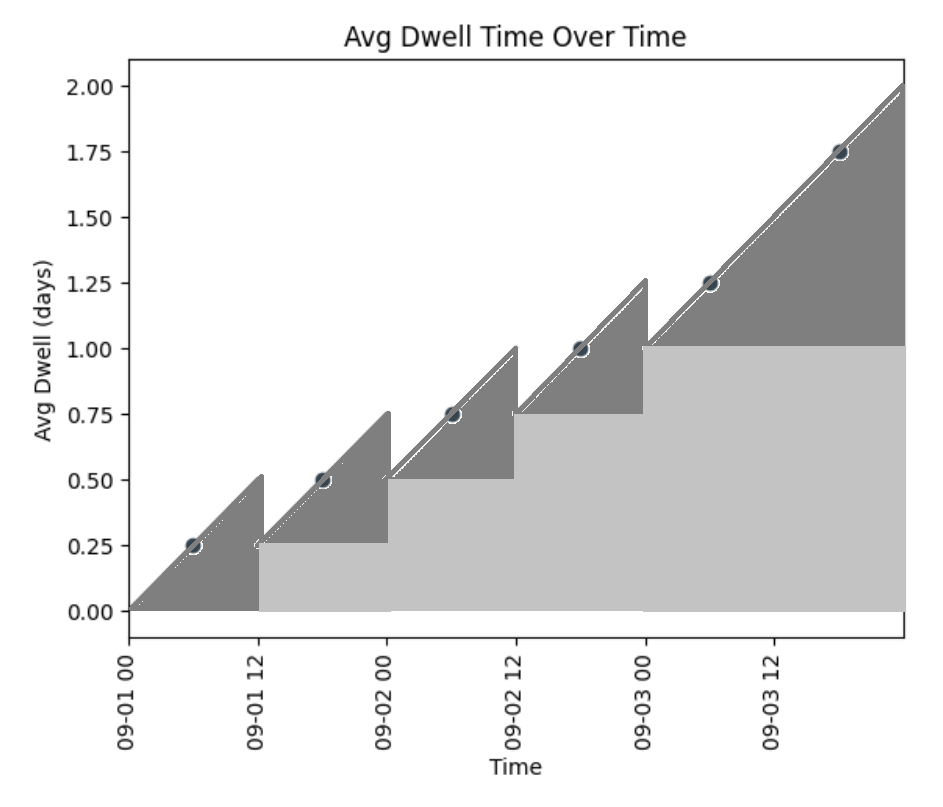

In [3]:
def fetch(df, method, timeframe, timeframe_is_date):
    if timeframe_is_date:
        return_value = (
            df.loc[
                (df['Method'] == method)
                & (df['Timeframe'] == pd.to_datetime(timeframe).date())
                , 'Avg Dwell'
            ].values[0]
        )
    else:
        return_value = (
            df.loc[
                (df['Method'] == method)
                & (df['Timeframe'] == timeframe)
                , 'Avg Dwell'
            ].values[0]
        )
    return(return_value)

In [4]:
def compose_test_result(method, timeframe, correct_value, actual_value):
    test_passes = (correct_value == actual_value)
    if test_passes:
        pass_fail_string = ' Passes'
    else:
        pass_fail_string = ' Fails'
    test_result_string = (
        pass_fail_string + ': ' 
        + 'Correct: ' + str(correct_value) 
        + '\tObtained: ' + str(actual_value) 
        + '\t' + method + ' ' + timeframe
    )
    return(test_passes, test_result_string)

In [5]:
def test(df, method, timeframe, is_date, correct_value):
    test_value = fetch(df, method, timeframe, is_date)
    (test_bool, test_string) = compose_test_result(method, timeframe, correct_value, test_value)
    return(test_bool, test_string)

In [6]:
def test_general(test_name, box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting):
    if debug_setting:
        print('\n' + test_name + ' begin\n')
        print('sample_gap: ' + str(sample_gap))
        print('first_day: ' + first_day)
        print('last_day: ' + last_day)
    results = dwell_times(box_schedules, sample_gap, first_day, last_day, print_setting, debug_setting, overlay_setting)
    if debug_setting:
        print('results:')
        print(results)
        print('\n')
    num_tests = len(tests)
    test_results = [None] * num_tests
    test_strings = [None] * num_tests
    for i in range(num_tests):
        (test_results[i], test_strings[i]) = test(results, tests[i][0], tests[i][1], tests[i][2], tests[i][3])
    test_result = all(test_results)
    if debug_setting:
        for test_string in test_strings:
            print(test_string)
        print(str(test_result) + ': ' + test_name)
    return(test_result)

In [7]:
def test_primary(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
        'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 12
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 0.9],
        ['Integration', '2024-09-01', True, 0.4],
        ['Integration', '2024-09-02', True, 0.9],
        ['Integration', '2024-09-03', True, 1.5],
        ['Integration', 'Avg Over Days', False, 0.9],
        ['Sampling', 'Entire Period', False, 0.9],
        ['Sampling', '2024-09-01', True, 0.4],
        ['Sampling', '2024-09-02', True, 0.9],
        ['Sampling', '2024-09-03', True, 1.5],
        ['Sampling', 'Avg Over Days', False, 0.9],
        ['Ratio', 'Entire Period', False, 0.8],
        ['Ratio', '2024-09-01', True, 0.4],
        ['Ratio', '2024-09-02', True, 0.8],
        ['Ratio', '2024-09-03', True, 1.5],
        ['Ratio', 'Avg Over Days', False, 0.9],
        ['Mainsail', 'Entire Period', False, 1.3],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_primary', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [8]:
def test_primary_first_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
        'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-02'
    tests = [
        ['Integration', 'Entire Period', False, 0.6],
        ['Integration', '2024-09-01', True, 0.4],
        ['Integration', '2024-09-02', True, 0.9],
        ['Integration', 'Avg Over Days', False, 0.6],
        ['Sampling', 'Entire Period', False, 0.6],
        ['Sampling', '2024-09-01', True, 0.4],
        ['Sampling', '2024-09-02', True, 0.9],
        ['Sampling', 'Avg Over Days', False, 0.6],
        ['Ratio', 'Entire Period', False, 0.7],
        ['Ratio', '2024-09-01', True, 0.4],
        ['Ratio', '2024-09-02', True, 0.8],
        ['Ratio', 'Avg Over Days', False, 0.6],
        ['Mainsail', 'Entire Period', False, 1.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_primary_first_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [9]:
def test_primary_last_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-01 12:00:00', '2024-09-02 00:00:00'],
        'departure': ['2024-09-02 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-02'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 1.2],
        ['Integration', '2024-09-02', True, 0.9],
        ['Integration', '2024-09-03', True, 1.5],
        ['Integration', 'Avg Over Days', False, 1.2],
        ['Sampling', 'Entire Period', False, 1.2],
        ['Sampling', '2024-09-02', True, 0.9],
        ['Sampling', '2024-09-03', True, 1.5],
        ['Sampling', 'Avg Over Days', False, 1.2],
        ['Ratio', 'Entire Period', False, 1.0],
        ['Ratio', '2024-09-02', True, 0.8],
        ['Ratio', '2024-09-03', True, 1.5],
        ['Ratio', 'Avg Over Days', False, 1.2],
        ['Mainsail', 'Entire Period', False, 1.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_primary_last_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [10]:
def test_some_no_inventory(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-02 12:00:00', '2024-09-03 12:00:00'],
        'departure': ['2024-09-01 12:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 0.1],
        ['Integration', '2024-09-01', True, 0.1],
        ['Integration', '2024-09-02', True, 0.1],
        ['Integration', '2024-09-03', True, 0.1],
        ['Integration', 'Avg Over Days', False, 0.1],
        ['Sampling', 'Entire Period', False, 0.1],
        ['Sampling', '2024-09-01', True, 0.1],
        ['Sampling', '2024-09-02', True, 0.1],
        ['Sampling', '2024-09-03', True, 0.1],
        ['Sampling', 'Avg Over Days', False, 0.1],
        ['Ratio', 'Entire Period', False, 0.2],
        ['Ratio', '2024-09-01', True, 0.2],
        ['Ratio', '2024-09-02', True, 0.2],
        ['Ratio', '2024-09-03', True, 0.2],
        ['Ratio', 'Avg Over Days', False, 0.2],
        ['Mainsail', 'Entire Period', False, 0.3],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_some_no_inventory', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [11]:
def test_no_starting_inventory(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 03:00:00', '2024-09-02 12:00:00', '2024-09-03 12:00:00'],
        'departure': ['2024-09-01 15:00:00', '2024-09-03 00:00:00', '2024-09-03 23:59:59']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 0.1],
        ['Integration', '2024-09-01', True, 0.1],
        ['Integration', '2024-09-02', True, 0.1],
        ['Integration', '2024-09-03', True, 0.1],
        ['Integration', 'Avg Over Days', False, 0.1],
        ['Sampling', 'Entire Period', False, 0.1],
        ['Sampling', '2024-09-01', True, 0.1],
        ['Sampling', '2024-09-02', True, 0.1],
        ['Sampling', '2024-09-03', True, 0.1],
        ['Sampling', 'Avg Over Days', False, 0.1],
        ['Ratio', 'Entire Period', False, 0.2],
        ['Ratio', '2024-09-01', True, 0.2],
        ['Ratio', '2024-09-02', True, 0.2],
        ['Ratio', '2024-09-03', True, 0.2],
        ['Ratio', 'Avg Over Days', False, 0.2],
        ['Mainsail', 'Entire Period', False, 0.3],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_starting_inventory', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [12]:
def test_no_ending_inventory(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 00:00:00', '2024-09-02 12:00:00', '2024-09-03 09:00:00'],
        'departure': ['2024-09-01 12:00:00', '2024-09-03 00:00:00', '2024-09-03 21:00:00']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 0.1],
        ['Integration', '2024-09-01', True, 0.1],
        ['Integration', '2024-09-02', True, 0.1],
        ['Integration', '2024-09-03', True, 0.1],
        ['Integration', 'Avg Over Days', False, 0.1],
        ['Sampling', 'Entire Period', False, 0.1],
        ['Sampling', '2024-09-01', True, 0.1],
        ['Sampling', '2024-09-02', True, 0.1],
        ['Sampling', '2024-09-03', True, 0.1],
        ['Sampling', 'Avg Over Days', False, 0.1],
        ['Ratio', 'Entire Period', False, 0.2],
        ['Ratio', '2024-09-01', True, 0.2],
        ['Ratio', '2024-09-02', True, 0.2],
        ['Ratio', '2024-09-03', True, 0.2],
        ['Ratio', 'Avg Over Days', False, 0.2],
        ['Mainsail', 'Entire Period', False, 0.3],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_ending_inventory', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [13]:
def test_no_inventory_first_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 03:00:00', '2024-09-02 09:00:00', '2024-09-03 09:00:00'],
        'departure': ['2024-09-01 15:00:00', '2024-09-02 21:00:00', '2024-09-03 21:00:00']
    }
    sample_gap = 3
    first_day = '2024-09-01'
    last_day = '2024-09-02'
    tests = [
        ['Integration', 'Entire Period', False, 0.1],
        ['Integration', '2024-09-01', True, 0.1],
        ['Integration', '2024-09-02', True, 0.1],
        ['Integration', 'Avg Over Days', False, 0.1],
        ['Sampling', 'Entire Period', False, 0.1],
        ['Sampling', '2024-09-01', True, 0.1],
        ['Sampling', '2024-09-02', True, 0.1],
        ['Sampling', 'Avg Over Days', False, 0.1],
        ['Ratio', 'Entire Period', False, 0.2],
        ['Ratio', '2024-09-01', True, 0.2],
        ['Ratio', '2024-09-02', True, 0.2],
        ['Ratio', 'Avg Over Days', False, 0.2],
        ['Mainsail', 'Entire Period', False, 0.0],
        ['Mainsail', '2024-09-01', True, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_inventory_first_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [14]:
def test_no_inventory_last_two_days(print_setting, debug_setting, overlay_setting):
    box_schedules = {
        'container': ['A', 'B', 'C'],
        'arrival': ['2024-09-01 03:00:00', '2024-09-02 09:00:00', '2024-09-03 09:00:00'],
        'departure': ['2024-09-01 15:00:00', '2024-09-02 21:00:00', '2024-09-03 21:00:00']
    }
    sample_gap = 3
    first_day = '2024-09-02'
    last_day = '2024-09-03'
    tests = [
        ['Integration', 'Entire Period', False, 0.1],
        ['Integration', '2024-09-02', True, 0.1],
        ['Integration', '2024-09-03', True, 0.1],
        ['Integration', 'Avg Over Days', False, 0.1],
        ['Sampling', 'Entire Period', False, 0.1],
        ['Sampling', '2024-09-02', True, 0.1],
        ['Sampling', '2024-09-03', True, 0.1],
        ['Sampling', 'Avg Over Days', False, 0.1],
        ['Ratio', 'Entire Period', False, 0.2],
        ['Ratio', '2024-09-02', True, 0.2],
        ['Ratio', '2024-09-03', True, 0.2],
        ['Ratio', 'Avg Over Days', False, 0.2],
        ['Mainsail', 'Entire Period', False, 0.0],
        ['Mainsail', '2024-09-02', True, 0.0],
        ['Mainsail', '2024-09-03', True, 0.0],
        ['Mainsail', 'Avg Over Days', False, 0.0]
    ]
    test_result = test_general('test_no_inventory_last_two_days', box_schedules, sample_gap, first_day, last_day, tests, print_setting, debug_setting, overlay_setting)
    return(test_result)

In [15]:
print(str(test_primary(False, False, False))+ ' test_primary')
print(str(test_primary_first_two_days(False, False, False)) + ' test_primary_first_two_days')
print(str(test_primary_last_two_days(False, False, False)) + ' test_primary_last_two_days')
print(str(test_some_no_inventory(False, False, False)) + ' test_some_no_inventory')
print(str(test_no_starting_inventory(False, False, False)) + ' test_no_starting_inventory')
print(str(test_no_ending_inventory(False, False, False)) + ' test_no_ending_inventory')
print(str(test_no_inventory_first_two_days(False, False, False)) + ' test_no_inventory_first_two_days')
print(str(test_no_inventory_last_two_days(False, False, False)) + ' test_no_inventory_last_two_days')

True test_primary
True test_primary_first_two_days
True test_primary_last_two_days
True test_some_no_inventory
True test_no_starting_inventory
True test_no_ending_inventory
True test_no_inventory_first_two_days
True test_no_inventory_last_two_days


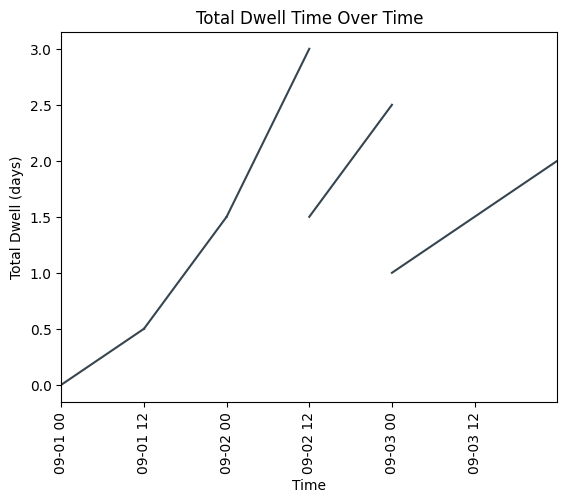

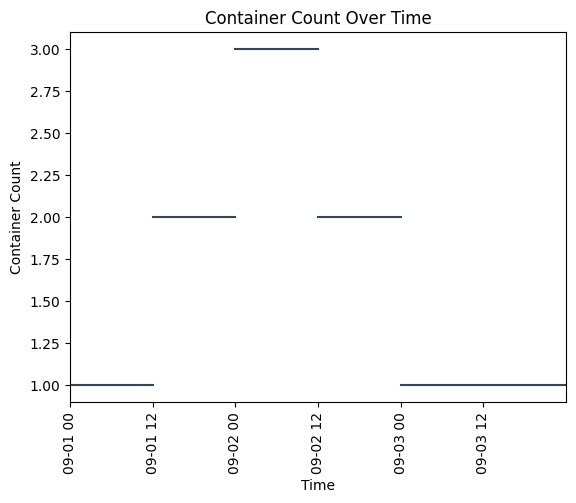

True

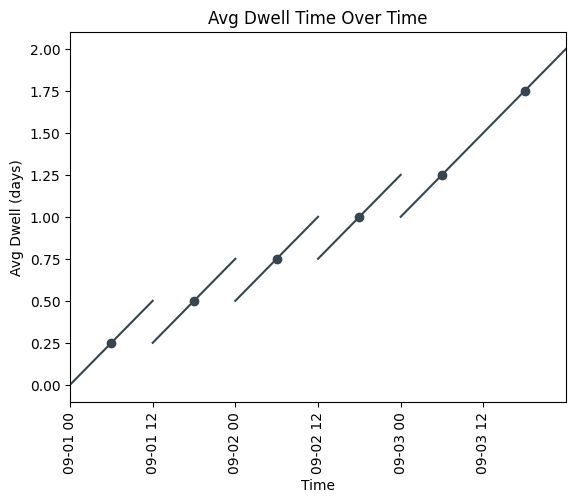

In [16]:
test_primary(True, False, True)

In [17]:
yrd120r_data = pd.read_csv('C:\\Users\\bjohnso\\OneDrive - Tideworks Technology\\YRD120R.csv', dtype=str)
sampling_interval = 12.0
first_day = '2024-09-29'
last_day = '2024-11-09'
print_setting = True
debug_setting = False
overlay_setting = False

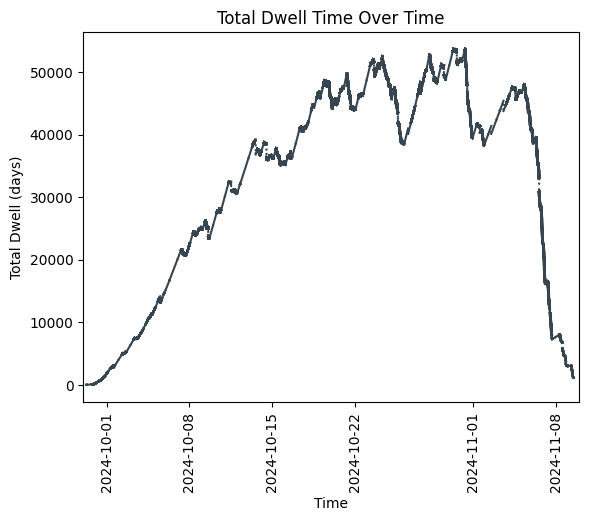

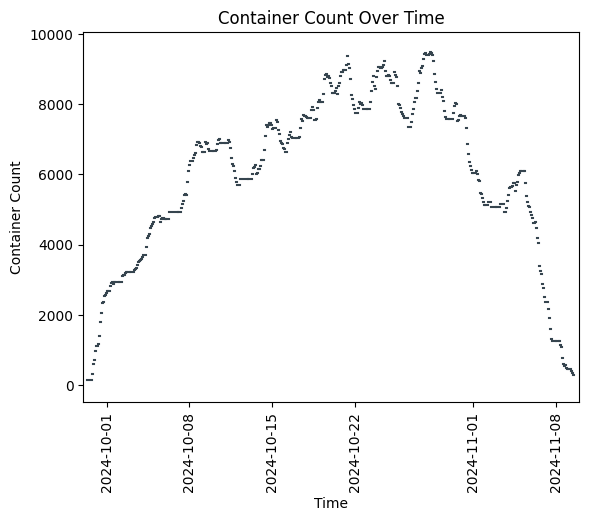

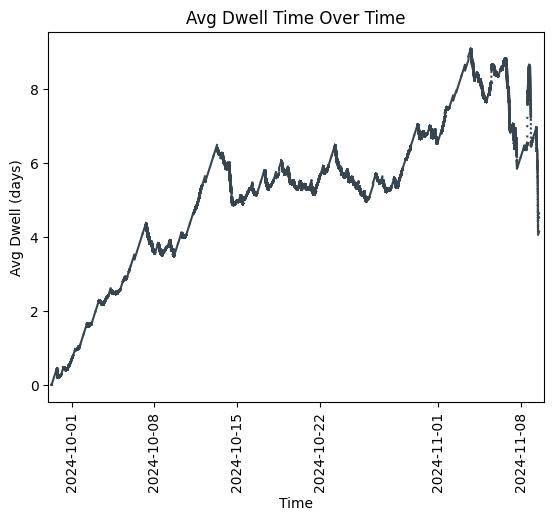

In [18]:
yrd120r_results = dwell_times(
    yrd120r_data, #.sample(n=100),
    sampling_interval, first_day, last_day,
    print_setting, debug_setting, overlay_setting
)

In [19]:
yrd120r_results.pivot_table(index='Method', columns='Timeframe', values='Avg Dwell')[['Avg Over Days', 'Entire Period']]

Timeframe,Avg Over Days,Entire Period
Method,,
Integration,5.1,5.1
Mainsail,0.0,5.7
Ratio,5.2,5.4
Sampling,5.2,5.1


In [20]:
crows_nest_data = pd.read_csv('C:\\Users\\bjohnso\\OneDrive - Tideworks Technology\\crows_nest_t18_yard.csv', dtype=str)
sampling_interval = 12.0
first_day = '2024-09-29'
last_day = '2024-11-09'
print_setting = True
debug_setting = False
overlay_setting = False

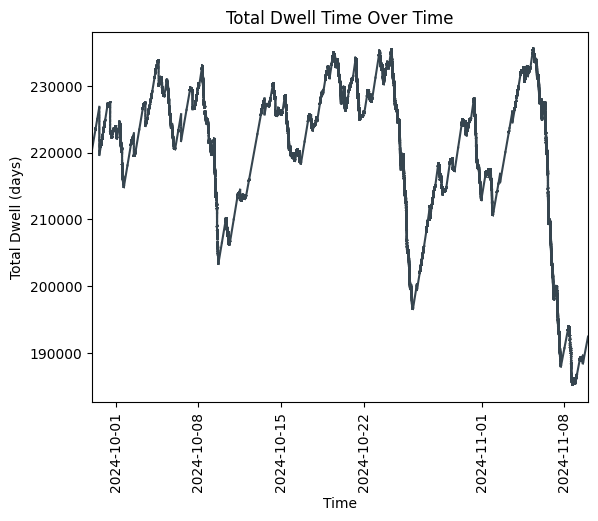

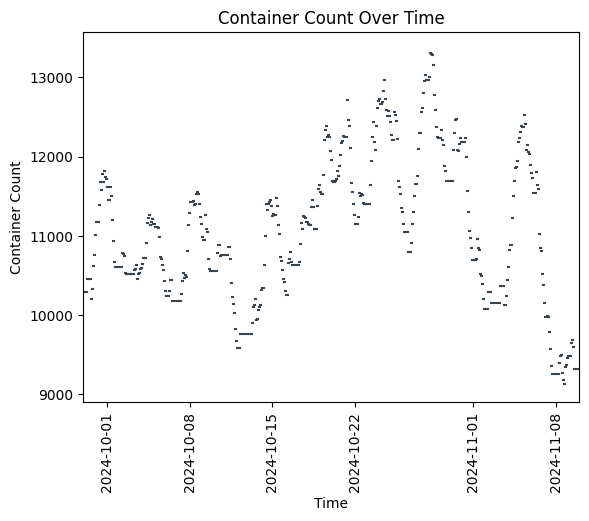

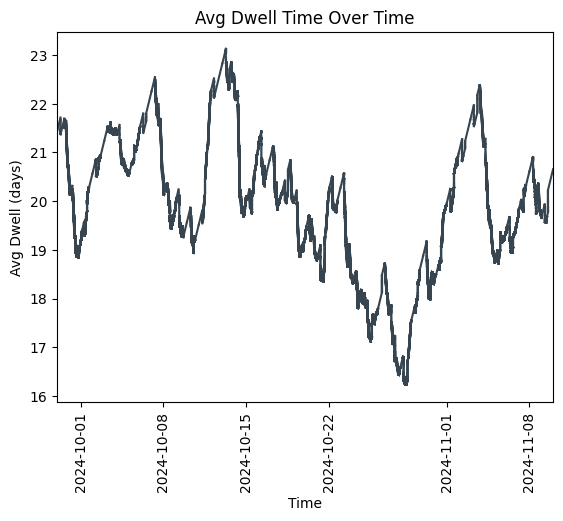

In [21]:
crows_nest_results = dwell_times(
    crows_nest_data, #.sample(n=100),
    sampling_interval, first_day, last_day,
    print_setting, debug_setting, overlay_setting
)

In [22]:
crows_nest_results.pivot_table(index='Method', columns='Timeframe', values='Avg Dwell')[['Avg Over Days', 'Entire Period']]

Timeframe,Avg Over Days,Entire Period
Method,,
Integration,20.0,20.0
Mainsail,0.0,5.7
Ratio,20.0,19.9
Sampling,20.1,20.1
